### Preface

This notebook was created and run within Google Colab using the free T4 GPU. 

Main resources used are the Huggingface websites specifically on Text Classification (https://huggingface.co/docs/transformers/tasks/sequence_classification).

### Imports and Data Loading

In [1]:
# Google Colab Python imports
%%capture
!pip install transformers datasets torch evaluate accelerate -U

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
)
from datasets import Dataset, DatasetDict, load_metric

import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_data_path = 'training.csv'
val_data_path = 'validation.csv'

column_names = ['id', 'topic', 'label', 'text']

In [4]:
train_data_df = pd.read_csv(train_data_path, names=column_names)
val_data_df = pd.read_csv(val_data_path, names=column_names)    

### Data Preparation

In [9]:
# Dropping irrelevant columns
train_data_df = train_data_df.drop(['id', 'topic'], axis=1)
val_data_df = val_data_df.drop(['id', 'topic'], axis=1)

# Dropping rows with missing text values
train_data_df = train_data_df.dropna()
val_data_df = val_data_df.dropna()

In [10]:
# Encode String Labels => Integer Labels (0, ..., 3)
label_encoder = LabelEncoder()

train_data_df['label'] = label_encoder.fit_transform(train_data_df['label'])
val_data_df['label'] = label_encoder.transform(val_data_df['label'])

In [11]:
# Rearranging Columns; doesn't actually matter, just for my sake
train_data_df = train_data_df[['text', 'label']]
val_data_df = val_data_df[['text', 'label']]

train_data_df = train_data_df.reset_index(drop=True)
val_data_df = val_data_df.reset_index(drop=True)

In [12]:
# Create Dataset Objects out of the DataFrames
train_dataset = Dataset.from_pandas(train_data_df)
val_dataset = Dataset.from_pandas(val_data_df)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'val': val_dataset,
})

In [13]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 73996
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})

In [16]:
train_dataset = dataset_dict["train"].shuffle(seed=42).select([i for i in list(range(5000))])

In [14]:
# Load pretrained tokenizer; in this case the distilbert-base model
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_train = dataset_dict["train"].map(preprocess_function, batched=True)
tokenized_val = dataset_dict["val"].map(preprocess_function, batched=True)

# Batch Builder used in the Training Process later; is able to apply minor processing steps, like padding in this case
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)base-uncased/resolve/main/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/73996 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Model Building/Training

In [15]:
# The 'basic' pretrained Distilbert model gets loaded and the head of the model replaced with new nodes and weights that will be finetuned on our data and task
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Definition of the Model Metric evaluation that should be used to evaluate the model
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, average='macro')["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [17]:
# Defining the Trainer Object that handles all the major training/evaluation things
training_args = TrainingArguments(
   output_dir="./sentiment_model_training",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="no",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_val,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [18]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.130600
1000,0.955600
1500,0.893200
2000,0.815700
2500,0.776500
3000,0.718700
3500,0.673300
4000,0.646000
4500,0.584900
5000,0.447100


TrainOutput(global_step=9250, training_loss=0.5685861453494511, metrics={'train_runtime': 1147.7126, 'train_samples_per_second': 128.945, 'train_steps_per_second': 8.06, 'total_flos': 2970801210296640.0, 'train_loss': 0.5685861453494511, 'epoch': 2.0})

In [19]:
trainer.evaluate()

<ipython-input-16-3fc67c8df202>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.1796828657388687,
 'eval_accuracy': 0.946,
 'eval_f1': 0.9448738677901392,
 'eval_runtime': 4.3611,
 'eval_samples_per_second': 229.302,
 'eval_steps_per_second': 14.446,
 'epoch': 2.0}

### Model Evaluation/Saving

In [21]:
predictions = trainer.predict(tokenized_val)
predictions[2]

{'test_loss': 0.1796828657388687,
 'test_accuracy': 0.946,
 'test_f1': 0.9448738677901392,
 'test_runtime': 4.4649,
 'test_samples_per_second': 223.971,
 'test_steps_per_second': 14.11}

In [22]:
trainer.save_model('sentiment_classifier')
tokenizer.save_pretrained('sentiment_tokenizer')

('sentiment_tokenizer/tokenizer_config.json',
 'sentiment_tokenizer/special_tokens_map.json',
 'sentiment_tokenizer/vocab.txt',
 'sentiment_tokenizer/added_tokens.json',
 'sentiment_tokenizer/tokenizer.json')

In [24]:
# Instantiate Trained Model to use for further Sentiment Classification
model = AutoModelForSequenceClassification.from_pretrained('./sentiment_classifier')
tokenizer = AutoTokenizer.from_pretrained('./sentiment_tokenizer')

classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

In [36]:
predictions = classifier(val_data_df['text'].values.tolist())
predictions = pd.DataFrame(predictions)
predictions.rename(columns={'label': 'label_prediction'}, inplace=True)
result = pd.concat([val_data_df, predictions], axis=1, join='inner')

# Process the Label Prediction
result['label_prediction'] = result['label_prediction'].str.replace('LABEL_', '')
result['label_prediction'] = result['label_prediction'].astype(int)

# Inverse Transform Labels
result['label'] = label_encoder.inverse_transform(result['label'])
result['label_prediction'] = label_encoder.inverse_transform(result['label_prediction'])

In [37]:
result

,text,label,label_prediction,score
0,I mentioned on Facebook that I was struggling ...,Irrelevant,Irrelevant,0.526029
1,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral,Neutral,0.997559
2,@Microsoft Why do I pay for WORD when it funct...,Negative,Negative,0.997516
3,"CSGO matchmaking is so full of closet hacking,...",Negative,Negative,0.995661
4,Now the President is slapping Americans in the...,Neutral,Neutral,0.998551
...,...,...,...,...
995,⭐️ Toronto is the arts and culture capital of ...,Irrelevant,Irrelevant,0.977002
996,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Irrelevant,Irrelevant,0.973605
997,Today sucked so it’s time to drink wine n play...,Positive,Positive,0.973092
998,Bought a fraction of Microsoft today. Small wins.,Positive,Positive,0.989840


In [38]:
accuracy_score(result['label'], result['label_prediction'])

0.946

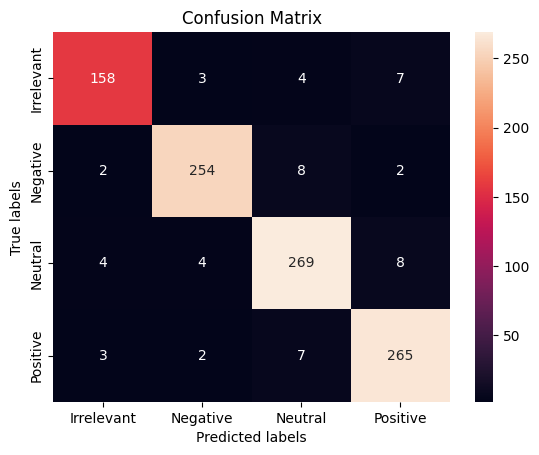

In [41]:
cm = confusion_matrix(result['label'], result['label_prediction'])

class_names = label_encoder.classes_

sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Summary

The basic general purpose model '*distilbert-base-uncased*' was fine-tuned on the downstream task of sentiment-analysis (sentence-classification).
Without optimizing hyperparameters and using more or less trivial starting configs an accuracy and f1 score of $0.946$ and $0.945$ was achieved, respectively.

With better/further preprocessing or bigger models even better performance could be achieved probably.

Trained model could additionally be pushed to the Huggingface model hub for easier sharing and usage.